In [1]:
import osu_beatmap_parser as obp
import models
import models_utils as m_utils

import io
import time
import pickle
import random
import requests

import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
# Constants
SKILLSET_LABELS = ["AIM", "STREAM", "ALT", "TECH", "SPEED", "RHYTHM"]
NUM_CLASSES = len(SKILLSET_LABELS)
INPUT_DIM = 13
MAX_SEQ_LEN = 142
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using Device:",device)
torch.set_default_device(device)
torch.set_float32_matmul_precision('high')

with open("data/beatmap_data.pkl", "rb") as pkl:
    chiv_data = pickle.load(pkl)

beatmaps_set_id, beatmaps_id, beatmaps_data, beatmaps_extra_data, beatmaps_skill = zip(*[(l[0],l[1],l[2],l[3],l[4])for l in chiv_data])

X_train, X_test, Xtra_train, Xtra_test, y_train, y_test = train_test_split(beatmaps_data, beatmaps_extra_data, beatmaps_skill, test_size=0.05, stratify=beatmaps_skill)

Using Device: cuda


In [3]:
def get_beatmap_from_website(id):
    url = f"https://osu.ppy.sh/osu/{id}"
    response = requests.get(url)
    if response.status_code == 200:
        text_file = io.StringIO(response.text.replace('\r', '')).readlines()
        beatmap = obp.Beatmap.str_to_beatmap(text_file)
    else:
        print("Could not get Beatmap with id: " + id)
        return None

    return beatmap

In [ ]:
model = models.SkillsetClassifier_v2_2()

In [35]:
#criterion = nn.BCEWithLogitsLoss()  #alternative loss function for multiclass
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)

#loads model weights
#PATH = "model_weights/osu_skills_v2.pth"
#model.load_state_dict(torch.load(PATH,weights_only=True))


In [36]:
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,100], gamma=0.1)


X_test_, Xtra_test_, y_test_ = m_utils.create_beatmaps_batch(X_test, Xtra_test, y_test, len(y_test))
X_test_ = torch.tensor(X_test_, dtype=torch.float32)
Xtra_test_ = torch.tensor(Xtra_test_, dtype=torch.float32)
y_test_ = torch.tensor(y_test_, dtype=torch.float32)
X_test_ = X_test_.unsqueeze(1)
X_test_ = X_test_.permute(0,1,3,2)


def train(model, epoch_length:int=5000, epochs:int=50, model_path:str="osu_skills_v2_2"):
    test_loss = 1e10
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i in range(epoch_length):
            # get the inputs; data is a list of [inputs, labels]
            inputs, _, y = m_utils.create_beatmaps_batch(X_train, Xtra_train, y_train, BATCH_SIZE)
            inputs = torch.tensor(inputs, dtype=torch.float32)
            inputs = inputs.unsqueeze(1) #for the cnn channels
            inputs = inputs.permute(0,1,3,2)
            #extra =  torch.tensor(extra, dtype=torch.float32)
            y = torch.tensor(y, dtype=torch.float32)
            # zero the parameter gradients
            #print(torch.isnan(inputs).any(), torch.isinf(inputs).any())
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / epoch_length:.4f}')
        scheduler.step()


        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_)
            val_loss = criterion(y_pred, y_test_)
            #if val_loss<test_loss:
            #    test_loss = val_loss
            if model_path:
                torch.save(model.state_dict(), f"model_weights/{model_path}.pth")
        print(f"Test val_loss: {val_loss:.4f}")
        model.train()

    print('Finished Training')

train(model, epoch_length=5000, epochs=20, model_path="osu_skills_v2_2")

[1,  5000] loss: 0.8703
Test val_loss: 1.9787
[2,  5000] loss: 0.8737
Test val_loss: 1.9835
[3,  5000] loss: 0.8719
Test val_loss: 1.9873
[4,  5000] loss: 0.8728
Test val_loss: 1.9167
[5,  5000] loss: 0.8714
Test val_loss: 1.9646
[6,  5000] loss: 0.8689
Test val_loss: 1.9790
[7,  5000] loss: 0.8702
Test val_loss: 1.9674
[8,  5000] loss: 0.8707
Test val_loss: 1.9626
[9,  5000] loss: 0.8741
Test val_loss: 1.9614
[10,  5000] loss: 0.8681
Test val_loss: 1.9892
[11,  5000] loss: 0.8713
Test val_loss: 1.9472
[12,  5000] loss: 0.8702
Test val_loss: 1.9577
[13,  5000] loss: 0.8702
Test val_loss: 2.0006
[14,  5000] loss: 0.8708
Test val_loss: 1.9437


KeyboardInterrupt: 

In [ ]:
test_inference = model(X_test_)

<BarContainer object of 6 artists>

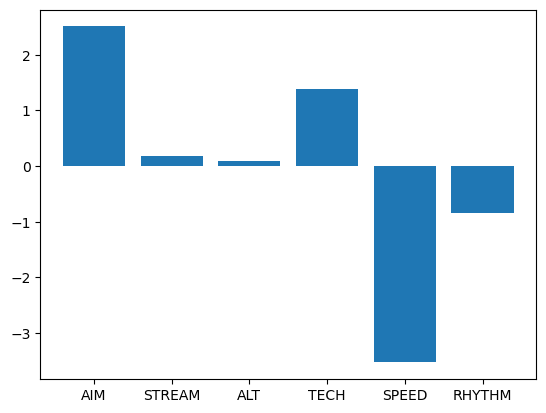

In [ ]:
plt.bar(SKILLSET_LABELS, test_inference[4].detach().cpu().numpy())

[90,  4000] loss: 0.711
Test val_loss: 3.7366950511932373

In [27]:
def visualize_beatmap_skillsets(model, beatmap:obp.Beatmap, dt:bool=False):
    def median_filter_columns(x: torch.Tensor, kernel_size: int) -> torch.Tensor:
        assert kernel_size % 2 == 1, "Kernel size must be odd"
        pad = kernel_size // 2
        
        # Expand to 3D: (1, rows, columns)
        x_3d = x.unsqueeze(0)
        # Pad the rows (dim=1), no padding on columns (dim=2)
        x_padded = f.pad(x_3d, (0, 0, pad, pad), mode='reflect')
        x_padded = x_padded.squeeze(0)  # Back to 2D

        # Unfold rows
        windows = x_padded.unfold(dimension=0, size=kernel_size, step=1)
        return windows.median(dim=2).values

    beatmap_sequence, extra = beatmap.beatmap_to_data()

    if dt: m_utils.apply_dt(beatmap_sequence, extra)
            
    beatmap_sequence = torch.tensor(beatmap_sequence, dtype=torch.float32)
    extra = torch.tensor(extra, dtype=torch.float32)
    #print(extra)
    skillspread = []
    step_size = MAX_SEQ_LEN//20
    skillvals = torch.zeros(((beatmap_sequence.shape[0]-MAX_SEQ_LEN)//step_size+1,len(SKILLSET_LABELS)))
    beatmap_sequence = beatmap_sequence.permute(1,0)
    j = 2
    #print(beatmap_sequence[None,:,j:j+MAX_SEQ_LEN].shape)
    for i,j in enumerate(range(0,beatmap_sequence.shape[1]-MAX_SEQ_LEN-1,step_size)):
        prediction = model(beatmap_sequence[None,None,:,j:j+MAX_SEQ_LEN])#, extra[None,:])
        #print(prediction)
        skillvals[i] = prediction
        skillspread.append(m_utils.decode_output(prediction))

    
    sm = nn.Softmax(dim=-1)
    kernel_size=5

    skillvals_filtered = median_filter_columns(skillvals, kernel_size)
    skillvals_filtered = torch.round(skillvals_filtered, decimals=1)
    skillvals_filtered = sm(skillvals_filtered)

    #print(skillspread)
    #print(skillvals)

    #skillvals_filtered = sm(skillvals)

    #time = [b.hit_object.time for b in beatmap.beatmap_objects]
    max_time = max(map(lambda b: b.hit_object.time, beatmap.beatmap_objects))
    min_time = min(map(lambda b: b.hit_object.time, beatmap.beatmap_objects))
    b_time = np.linspace(min_time,max_time, len(skillvals_filtered))
    b_time = b_time/1000/60

    skillvaluespread = skillvals_filtered.cpu().detach().numpy()
    bottom = np.zeros(len(b_time))

    cmap = plt.get_cmap("tab10")
    colors = [cmap(i) for i in range(len(SKILLSET_LABELS))]

    fig = plt.figure(figsize=(18, 5))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 3])
    fig.suptitle(beatmap.metadata.title)

    ax1 = fig.add_subplot(gs[0, 1])
    ax1.grid(color="gray", linestyle="--", alpha=0.2)
    ax1.margins(x=0, y=0)
    ax1.set_ylim(0,1)

    for i,la in enumerate(SKILLSET_LABELS):
        ax1.plot(b_time,skillvaluespread[:,i], label=la)
        ax1.fill_between(b_time, skillvaluespread[:,i],bottom, alpha=0.2)
    ax1.set_xticks((np.linspace(min(b_time),max(b_time),15)).round(2))
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()

    ax2 = fig.add_subplot(gs[1, 1])
    ax2.stackplot(b_time,
                       skillvaluespread[:,0],skillvaluespread[:,1],skillvaluespread[:,2],skillvaluespread[:,3],
                       skillvaluespread[:,4],skillvaluespread[:,5],
                       labels=SKILLSET_LABELS, baseline="zero", alpha=0.9, edgecolor="black", linewidth=1)
    ax2.set_xticks((np.linspace(min(b_time),max(b_time),15)).round(2))
    ax2.grid(color="gray", linestyle="--", alpha=0.1)
    ax2.margins(x=0, y=0)
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()

    ax3 = fig.add_subplot(gs[:, 0])
    ax3.barh(y=SKILLSET_LABELS, width=np.sum(skillvaluespread, axis=0)/np.sum(skillvaluespread), color=colors, edgecolor="black")
    ax3.invert_yaxis()
    ax3.invert_xaxis()
    yticklabels = ax3.get_yticklabels()
    for label, color in zip(yticklabels, colors):
        label.set_color(color)
        label.set_fontsize('x-large')
    #ax3.yaxis.set_label_position("right")
    #ax3.yaxis.tick_right()

    plt.tight_layout()
    plt.show()
    time.sleep(1)

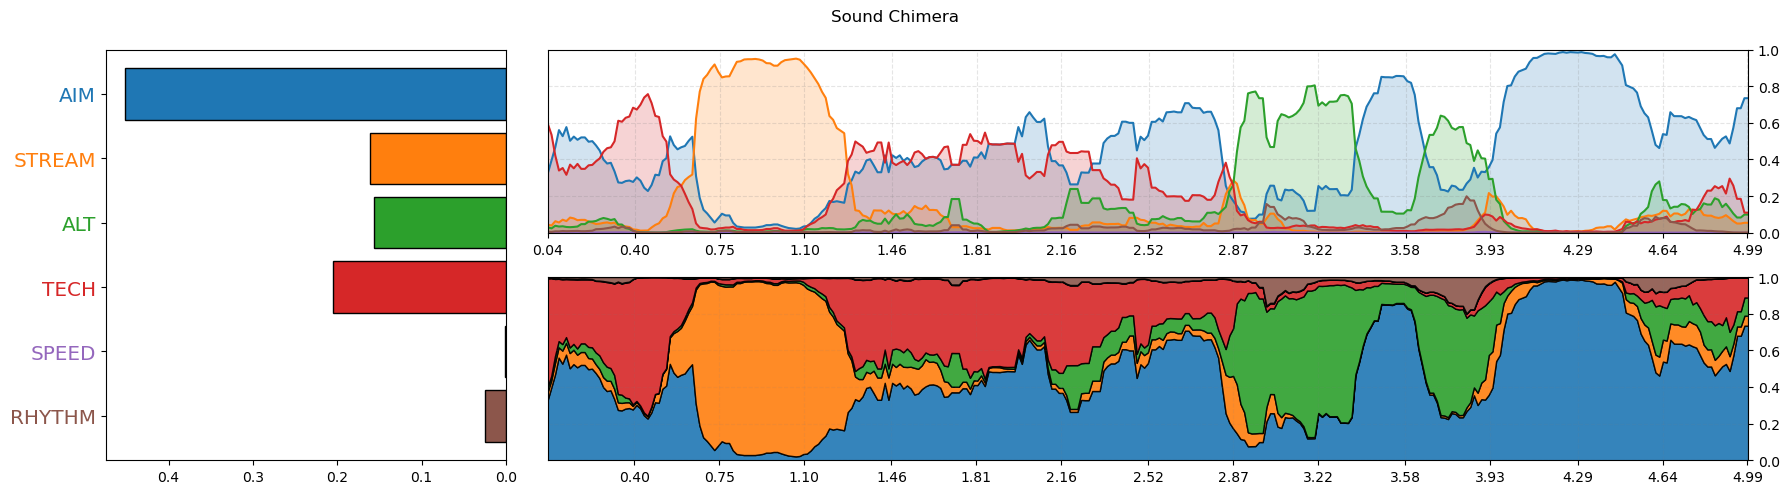

In [28]:
beatmap = obp.Beatmap.file_to_beatmap("E:\\osu!\\Songs\\Laur - Sound Chimera\\Laur - Sound Chimera (Nattu) [Chimera].osu")
visualize_beatmap_skillsets(model, beatmap)

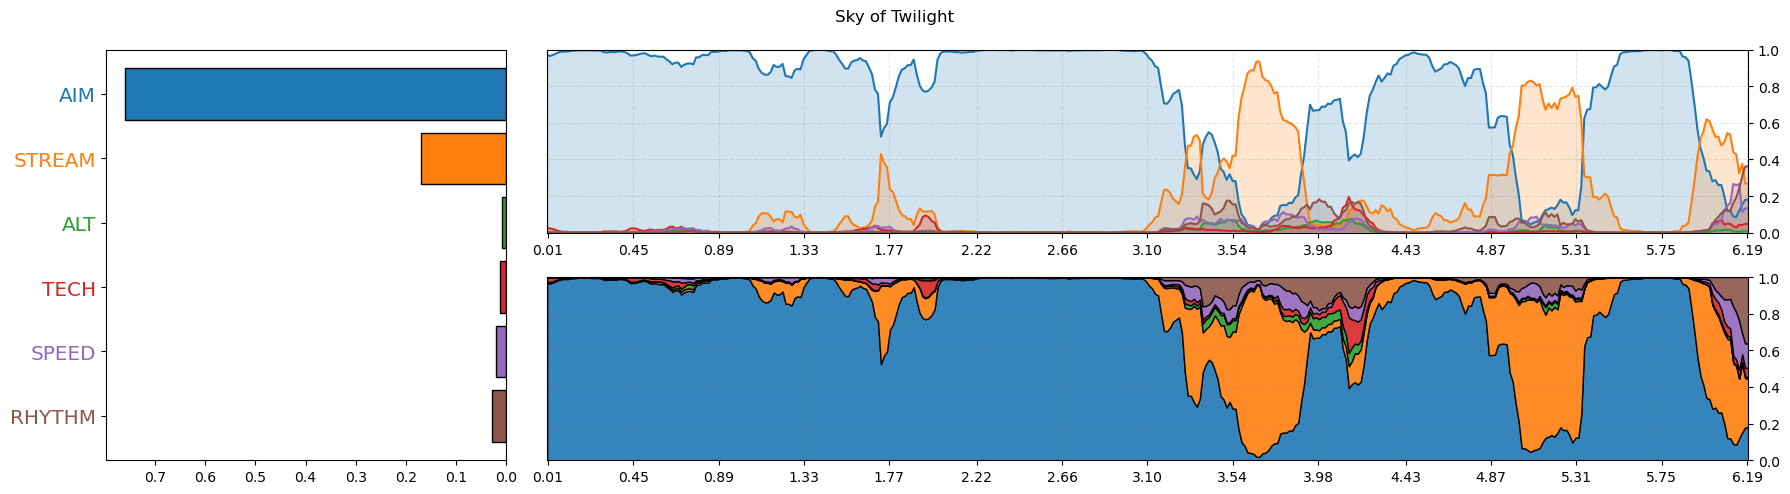

In [29]:
beatmap = get_beatmap_from_website(4881501)
visualize_beatmap_skillsets(model, beatmap)

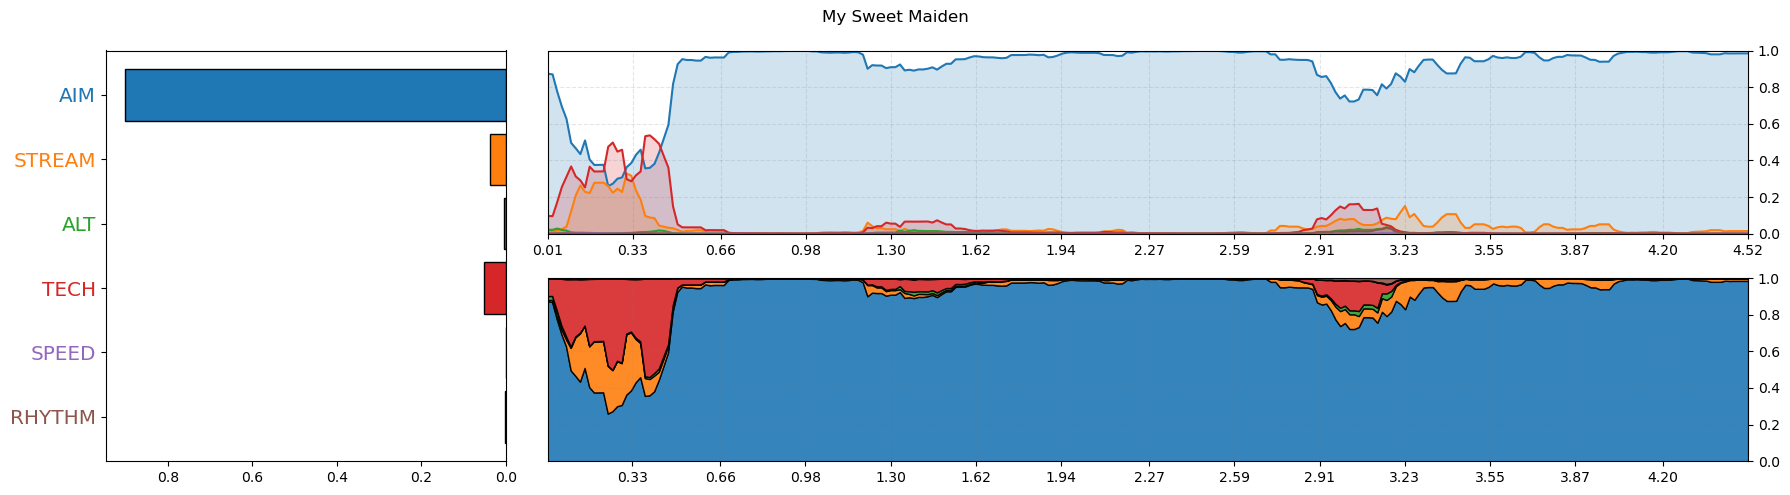

In [30]:
beatmap = get_beatmap_from_website(2692144)
visualize_beatmap_skillsets(model, beatmap, False)

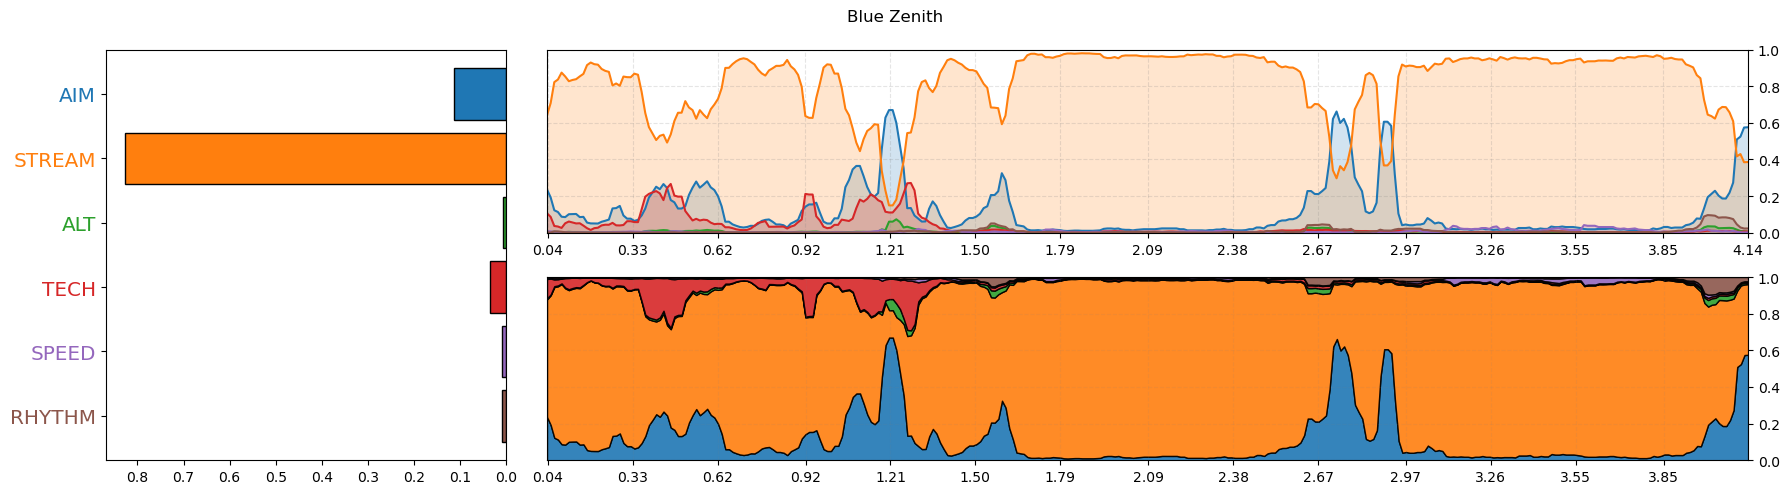

In [31]:
beatmap = get_beatmap_from_website(658127)
a = visualize_beatmap_skillsets(model, beatmap, dt=False)

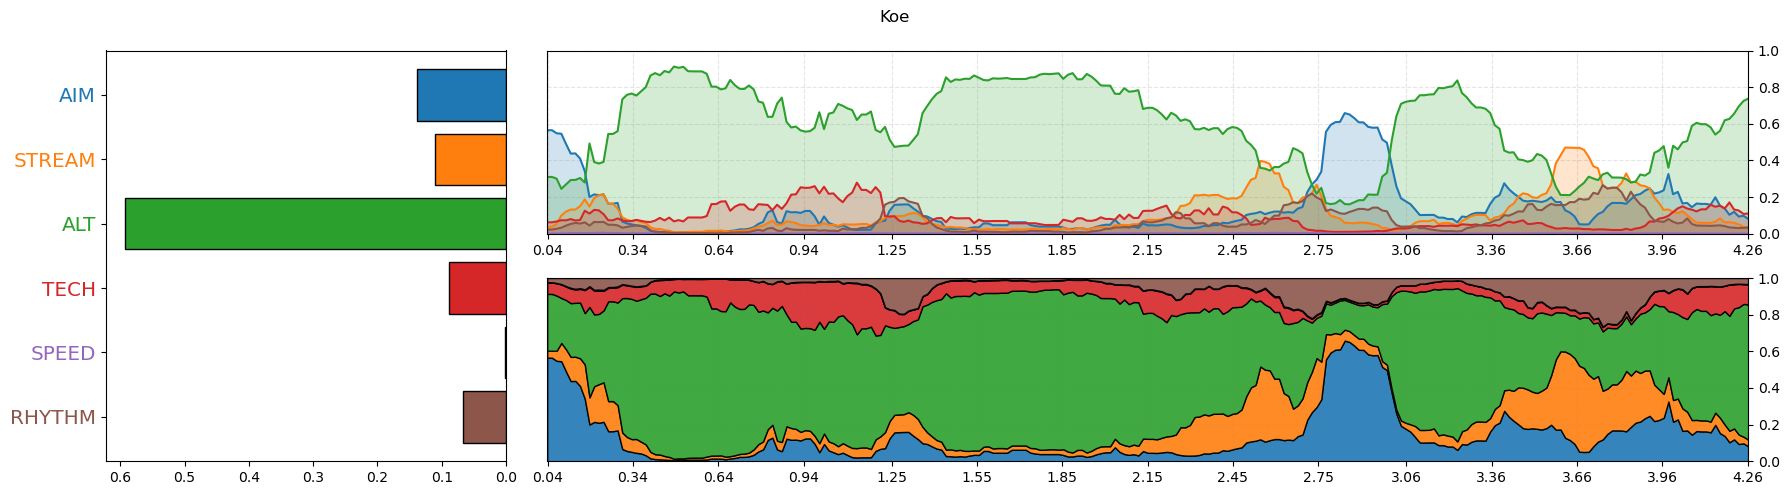

In [32]:
beatmap = get_beatmap_from_website(3879769)
a = visualize_beatmap_skillsets(model, beatmap, dt=False)

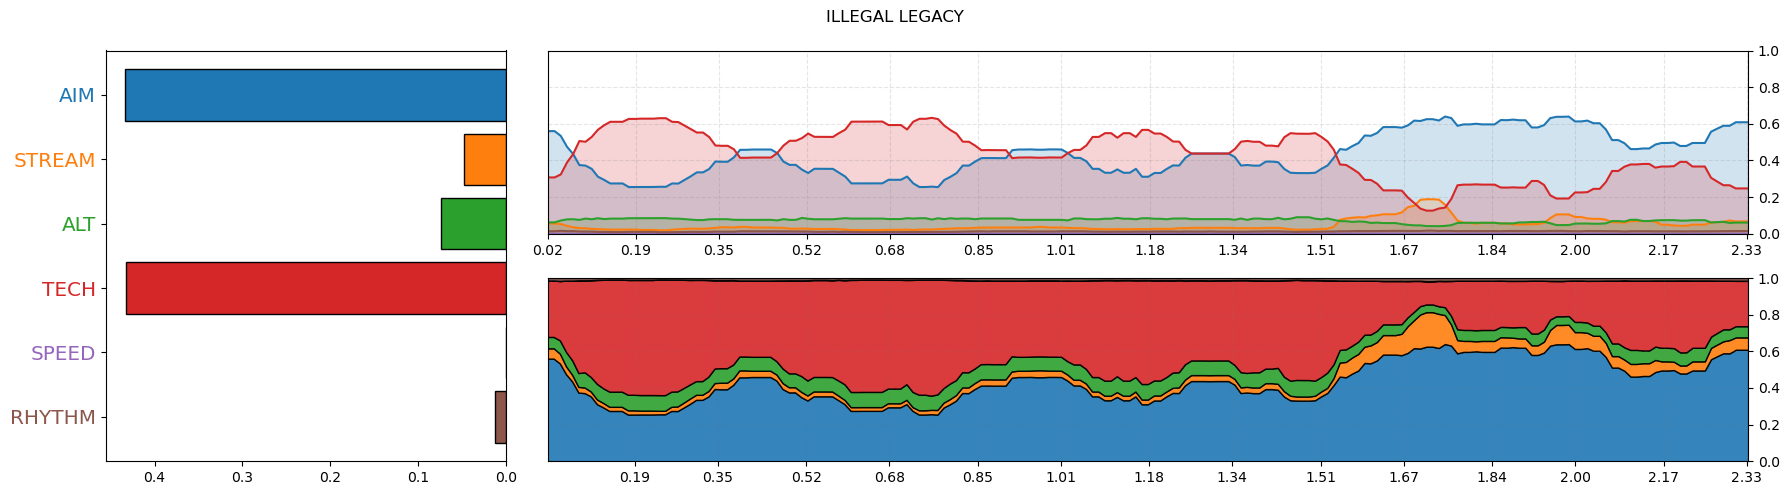

In [ ]:
beatmap = get_beatmap_from_website(3333703)
a = visualize_beatmap_skillsets(model, beatmap, dt=False)

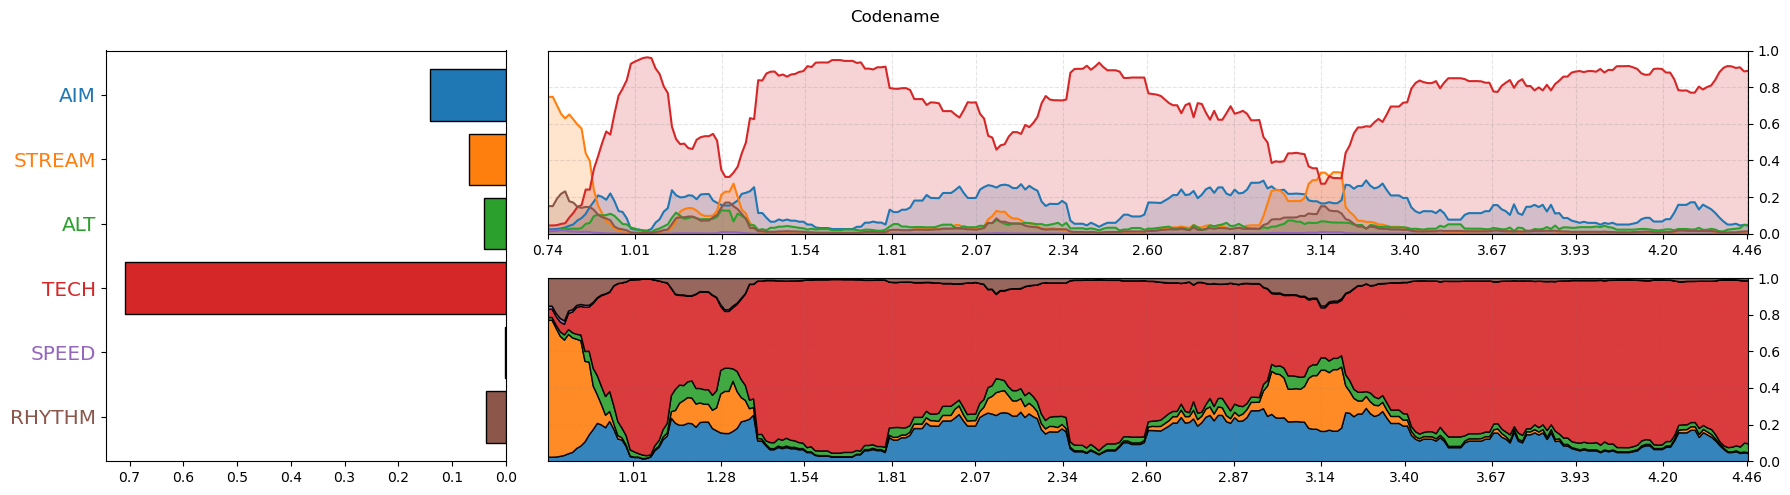

In [ ]:
beatmap = get_beatmap_from_website(3066436)
a = visualize_beatmap_skillsets(model, beatmap, dt=False)

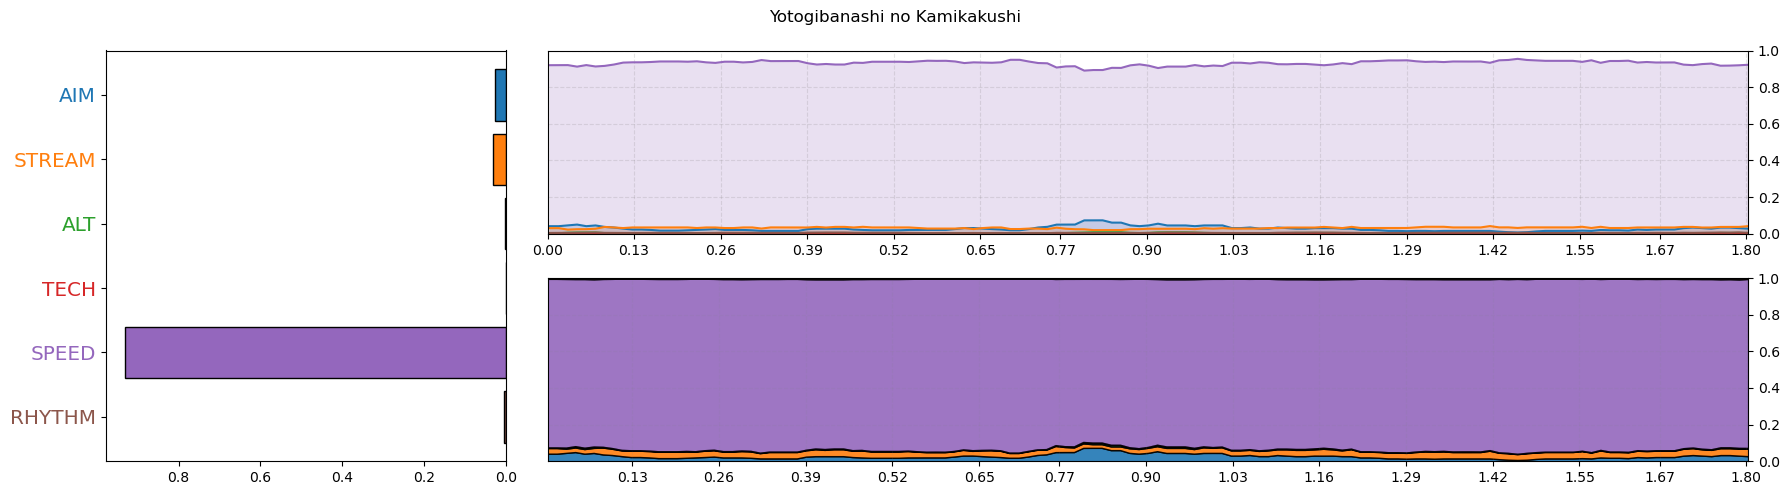

In [ ]:
beatmap = get_beatmap_from_website(3933767)
visualize_beatmap_skillsets(model, beatmap, False)

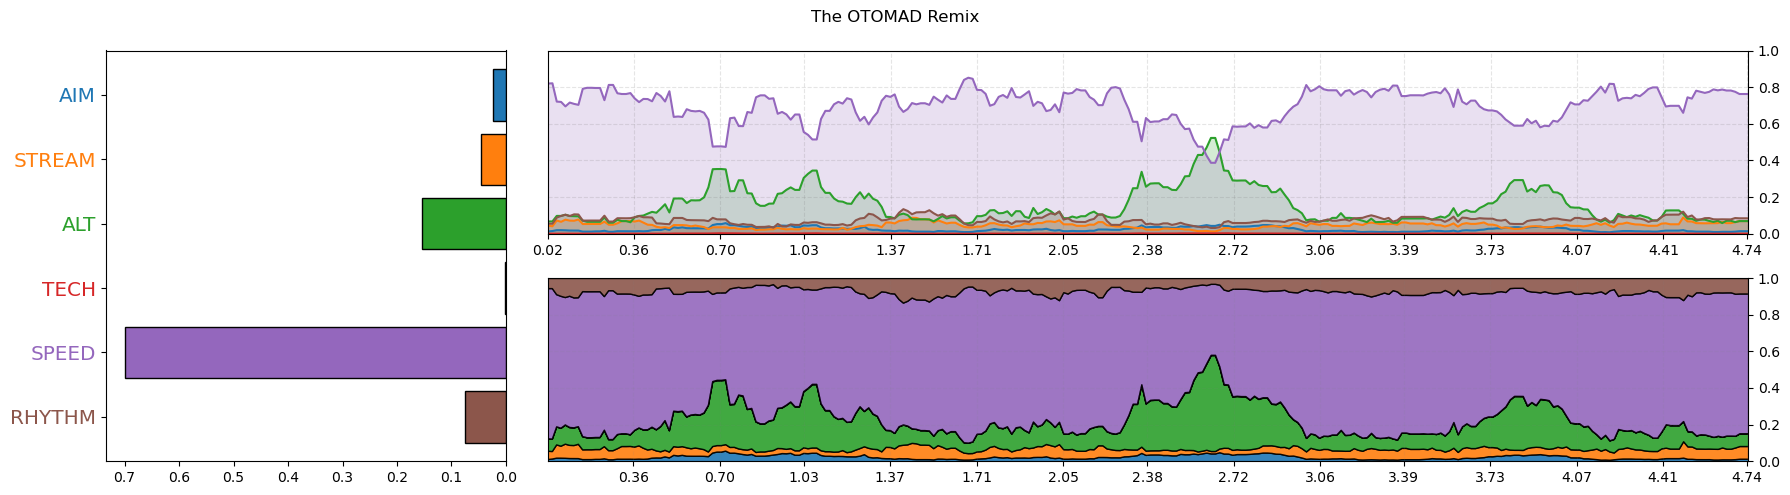

In [ ]:
beatmap = get_beatmap_from_website(317460)
a = visualize_beatmap_skillsets(model, beatmap, dt=True)

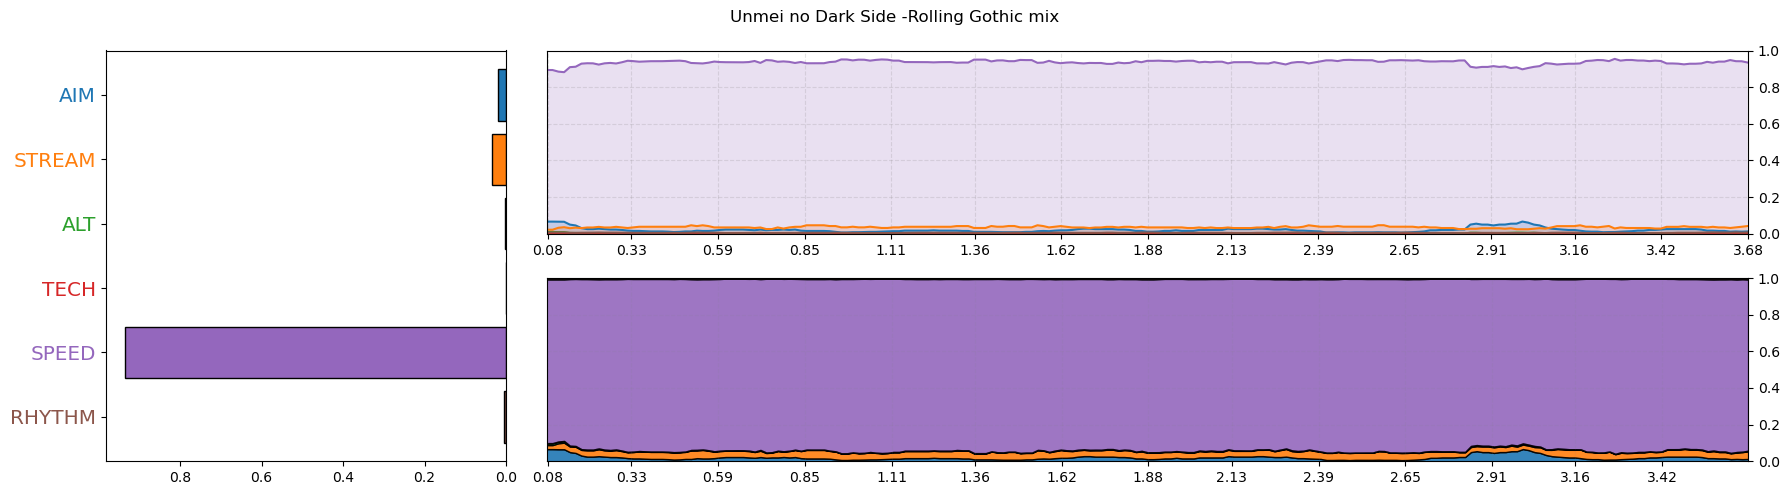

In [ ]:
beatmap = get_beatmap_from_website(4881745)
visualize_beatmap_skillsets(model, beatmap, True)